# REGCOIL
This example reproduces REGCOIL results, and performs a Taylor test
that compares QUADCOIL derivatives with the results yielded by 
finite-differencing many REGCOIL results. 

This notebook requires the regcoil branch of simsopt for running 
REGCOIL and loading data. QUADCOIL itself does not depend on 
Simsopt or REGCOIL.

In [1]:
from quadcoil import quadcoil

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import block_until_ready
import time

In [3]:
from simsopt.field.magneticfieldclasses import WindingSurfaceField
from simsopt.geo import SurfaceRZFourier 
from simsopt import load
from simsopt.field import CurrentPotentialFourier, CurrentPotentialSolve

## Loading data

In [4]:
winding_surface, plasma_surface = load('surfaces.json')
cp = CurrentPotentialFourier(
    winding_surface, mpol=4, ntor=4,
    net_poloidal_current_amperes=11884578.094260072,
    net_toroidal_current_amperes=0,
    stellsym=True)

/home/lankef/code/simsopt/src/simsopt/_core/optimizable.py:1630: EncodingWarning: We strongly encourage explicit `encoding`, and we would use UTF-8 by default as per PEP 686
  with zopen(filename, "rt") as fp:


## Solving the REGCOIL problem (automatic winding surface)
QUADCOIL inputs are strings and numpy/jax.numpy arrays. 


It only requires 
`from quadcoil import quadcoil`
unless non-default winding surface generators are required.


In [5]:
# First, test with the REGCOIL problem, auto-generating WS.
print('Running REGCOIL, with auto-generated winding surface')
regcoil1_phi_mn, regcoil1_out_dict, regcoil1_qp = quadcoil(
    nfp=cp.nfp,
    stellsym=cp.stellsym,
    mpol=cp.mpol,
    ntor=cp.ntor,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=cp.net_poloidal_current_amperes,
    net_toroidal_current_amperes=cp.net_toroidal_current_amperes,
    plasma_coil_distance=plasma_surface.minor_radius(),
    # Set the objective to 
    # f_B + 0.01 f_K
    objective_name=('f_B', 'f_K'),
    objective_weight=(1., 0.01),
    # Usually we recommend normalizing f_B and f_K to 
    # ~1, but in this case, for testing prupose, not normalizing 
    # is also okay
    objective_unit=(1., 1.), 
    # Set the output metrics to f_B and f_K
    metric_name=('f_B', 'f_K')
)

Running REGCOIL, with auto-generated winding surface
objective_unit (1.0, 1.0)
objective_unit (1.0, 1.0)
objective_unit (1.0, 1.0)


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


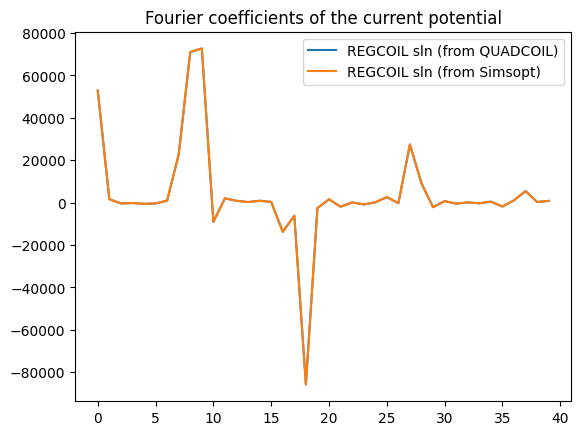

In [6]:
# Extract the winding surface and run REGCOIL
ws1 = regcoil1_qp.winding_surface.to_simsopt()
cp1 = CurrentPotentialFourier(
    ws1, mpol=cp.mpol, ntor=cp.ntor,
    net_poloidal_current_amperes=cp.net_poloidal_current_amperes,
    net_toroidal_current_amperes=cp.net_toroidal_current_amperes,
    stellsym=True)
cpst1 = CurrentPotentialSolve(cp1, plasma_surface, 0)
regcoil1_phi_mn_ans, regcoil1_f_B_ans, regcoil1_f_K_ans = cpst1.solve_tikhonov(lam=0.01)
plt.title('Fourier coefficients of the current potential')
plt.plot(regcoil1_phi_mn, label='REGCOIL sln (from QUADCOIL)')
plt.plot(regcoil1_phi_mn_ans, label='REGCOIL sln (from Simsopt) ')
plt.legend()

## Running the REGCOIL problem (given winding surface)

In [7]:
# Then, test with REGCOIL, given winding surface.
print('Testing REGCOIL, with known winding surface')
regcoil2_phi_mn, regcoil2_out_dict, regcoil2_qp = quadcoil(
    nfp=cp.nfp,
    stellsym=cp.stellsym,
    mpol=cp.mpol,
    ntor=cp.ntor,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=cp.net_poloidal_current_amperes,
    net_toroidal_current_amperes=cp.net_toroidal_current_amperes,
    winding_dofs=winding_surface.get_dofs(),
    winding_mpol=winding_surface.mpol,
    winding_ntor=winding_surface.ntor,
    winding_quadpoints_phi=winding_surface.quadpoints_phi,
    winding_quadpoints_theta=winding_surface.quadpoints_theta,
    objective_name=('f_B', 'f_K'),
    objective_weight=(1., 0.01),
    metric_name=('f_B', 'f_K')
)

Testing REGCOIL, with known winding surface
objective_unit None
objective_unit None
objective_unit None


/home/lankef/code/quadcoil/src/quadcoil/quadcoil.py:164: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  y_dict_current['objective_weight_eff'] = jnp.array(objective_weight)/jnp.array(objective_unit)


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


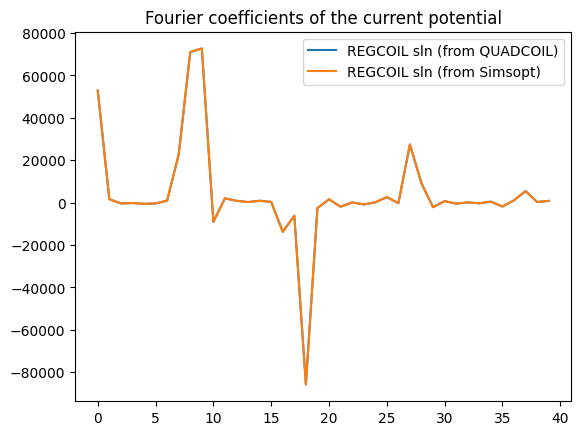

In [8]:
# Comparing with REGCOIL
cpst = CurrentPotentialSolve(cp, plasma_surface, jnp.zeros(1024))
regcoil2_phi_mn_ans, regcoil2_f_B_ans, regcoil2_f_K_ans = cpst.solve_tikhonov(lam=0.01)
plt.title('Fourier coefficients of the current potential')
plt.plot(regcoil1_phi_mn, label='REGCOIL sln (from QUADCOIL)')
plt.plot(regcoil1_phi_mn_ans, label='REGCOIL sln (from Simsopt) ')
plt.legend()

## Taylor test
Test QUADCOIL derivatives against REGCOIL + finite difference

In [9]:
plasma_dof_orig = plasma_surface.get_dofs()
plasma_dof_0_list = []
phi_test_list = []
f_B_test_list = []
f_K_test_list = []
phi_ans_list = []
f_B_ans_list = []
f_K_ans_list = []
f_B_diff_test_list = []
f_K_diff_test_list = []
time_quadcoil_list = []
time_regcoil_list = []
for i in jnp.linspace(-0.1, 0.1, 200):
    plasma_dof_i = plasma_dof_orig.copy()
    plasma_dof_i[0] *= (1 + i)
    # Run QUADCOIL first
    time1 = time.time()
    regcoili_phi_mn, regcoili_out_dict, regcoili_qp = quadcoil(
        nfp=cp.nfp,
        stellsym=cp.stellsym,
        mpol=cp.mpol,
        ntor=cp.ntor,
        plasma_dofs=plasma_dof_i,
        plasma_mpol=cpst.plasma_surface.mpol,
        plasma_ntor=cpst.plasma_surface.ntor,
        net_poloidal_current_amperes=cp.net_poloidal_current_amperes,
        net_toroidal_current_amperes=cp.net_toroidal_current_amperes,
        plasma_coil_distance=plasma_surface.minor_radius(),
        objective_name=('f_B', 'f_K'),
        objective_weight=(1., 0.01),
        objective_unit=(1., 1.),
        metric_name=('f_B', 'f_K')
    )
    block_until_ready(regcoili_phi_mn)
    block_until_ready(regcoili_out_dict)
    block_until_ready(regcoili_qp)
    time2 = time.time()
    time_quadcoil_list.append(time2-time1)
    # REGCOIL ---------------------------------------------------
    time1 = time.time()
    plasma_dof_0_list.append(plasma_dof_i[0])
    phi_test_list.append(regcoili_phi_mn)
    f_B_test_list.append(regcoili_out_dict['f_B']['value'])
    f_K_test_list.append(regcoili_out_dict['f_K']['value'])
    f_B_diff_test_list.append(regcoili_out_dict['f_B']['grad']['df_dplasma_dofs'][0])
    f_K_diff_test_list.append(regcoili_out_dict['f_K']['grad']['df_dplasma_dofs'][0])
    wsi = regcoili_qp.winding_surface.to_simsopt()
    psi = regcoili_qp.plasma_surface.to_simsopt()
    cpi = CurrentPotentialFourier(
        wsi, mpol=cp.mpol, ntor=cp.ntor,
        net_poloidal_current_amperes=cp.net_poloidal_current_amperes,
        net_toroidal_current_amperes=cp.net_toroidal_current_amperes,
        stellsym=True)
    cpsti = CurrentPotentialSolve(cpi, psi, 0)
    regcoili_phi_mn_ans, regcoili_f_B_ans, regcoili_f_K_ans = cpsti.solve_tikhonov(0.01)
    time2 = time.time()
    time_regcoil_list.append(time2-time1)
    phi_ans_list.append(regcoili_phi_mn_ans)
    f_B_ans_list.append(regcoili_f_B_ans)
    f_K_ans_list.append(regcoili_f_K_ans)
print('QUADCOIL avg time:', np.average(time_quadcoil_list), '(s)')
print('QUADCOIL max time:', np.max(time_quadcoil_list), '(s)')
print('REGCOIL  avg time:', np.average(time_regcoil_list), '(s)')
print('REGCOIL  max time:', np.max(time_regcoil_list), '(s)')

objective_unit None
objective_unit None
objective_unit None


/home/lankef/code/quadcoil/src/quadcoil/quadcoil.py:164: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  y_dict_current['objective_weight_eff'] = jnp.array(objective_weight)/jnp.array(objective_unit)
ERROR:2025-03-15 12:44:31,364:jax._src.callback:96: jax.pure_callback failed
Traceback (most recent call last):
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/jax/_src/callback.py", line 94, in pure_callback_impl
    return tree_util.tree_map(np.asarray, callback(*args))
                                          ^^^^^^^^^^^^^^^
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/jax/_src/callback.py", line 71, in __call__
    return tree_util.tree_leaves(self.callback_func(*args, **kwargs))
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/equinox/_errors.py", line 89, in

XlaRuntimeError: INTERNAL: CustomCall failed: CpuCallback error: Traceback (most recent call last):
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/runpy.py", line 198, in _run_module_as_main
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/runpy.py", line 88, in _run_code
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/asyncio/base_events.py", line 645, in run_forever
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/asyncio/events.py", line 88, in _run
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/tmp/ipykernel_86620/2255938885.py", line 18, in <module>
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/jax/_src/pjit.py", line 337, in cache_miss
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/jax/_src/pjit.py", line 195, in _python_pjit_helper
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/jax/_src/pjit.py", line 1695, in _pjit_call_impl_python
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/jax/_src/profiler.py", line 333, in wrapper
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/jax/_src/interpreters/pxla.py", line 1289, in __call__
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py", line 2854, in _wrapped_callback
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/jax/_src/callback.py", line 286, in _callback
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/jax/_src/callback.py", line 97, in pure_callback_impl
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/jax/_src/callback.py", line 71, in __call__
  File "/home/lankef/.conda/envs/stellarator/lib/python3.12/site-packages/equinox/_errors.py", line 89, in raises
_EquinoxRuntimeError: The linear solver returned non-finite (NaN or inf) output. This usually means that the
operator was not well-posed, and that the solver does not support this.

If you are trying solve a linear least-squares problem then you should pass
`solver=AutoLinearSolver(well_posed=False)`. By default `lineax.linear_solve`
assumes that the operator is square and nonsingular.

If you *were* expecting this solver to work with this operator, then it may be because:

(a) the operator is singular, and your code has a bug; or

(b) the operator was nearly singular (i.e. it had a high condition number:
    `jnp.linalg.cond(operator.as_matrix())` is large), and the solver suffered from
    numerical instability issues; or

(c) the operator is declared to exhibit a certain property (e.g. positive definiteness)
    that is does not actually satisfy.


--------------------
An error occurred during the runtime of your JAX program! Unfortunately you do not appear to be using `equinox.filter_jit` (perhaps you are using `jax.jit` instead?) and so further information about the error cannot be displayed. (Probably you are seeing a very large but uninformative error message right now.) Please wrap your program with `equinox.filter_jit`.
--------------------


In [ ]:
regcoili_out_dict['f_B']['grad'].key()

In [ ]:
plasma_dof_0_list = jnp.array(plasma_dof_0_list)
phi_test_list = jnp.array(phi_test_list)
f_B_test_list = jnp.array(f_B_test_list)
f_K_test_list = jnp.array(f_K_test_list)
phi_ans_list = jnp.array(phi_ans_list)
f_B_ans_list = jnp.array(f_B_ans_list)
f_K_ans_list = jnp.array(f_K_ans_list)
f_B_diff_test_list = jnp.array(f_B_diff_test_list)
f_K_diff_test_list = jnp.array(f_K_diff_test_list)
time_quadcoil_list = jnp.array(time_quadcoil_list)
time_regcoil_list = jnp.array(time_regcoil_list)

In [ ]:
plt.plot(plasma_dof_0_list, f_K_test_list, label='QUADCOIL')
plt.plot(plasma_dof_0_list, f_K_ans_list, label='REGCOIL', linestyle='dashed')
plt.xlabel('$R_{00}$ of plasma surface')
plt.ylabel('$f_K$ (K$^2$m$^2$)')
plt.legend()
print('Max error:', jnp.max(jnp.abs(f_K_test_list - f_K_ans_list)))
print('Avg error:', jnp.average(jnp.abs(f_K_test_list - f_K_ans_list)))

In [ ]:
plt.plot(plasma_dof_0_list, f_B_test_list, label='QUADCOIL')
plt.plot(plasma_dof_0_list, f_B_ans_list, label='REGCOIL', linestyle='dashed')
plt.xlabel('$R_{00}$ of plasma surface')
plt.ylabel('$f_B$ (T$^2$m$^2$)')
plt.legend()
print('Max error:', jnp.max(jnp.abs(f_B_test_list - f_B_ans_list)))
print('Avg error:', jnp.average(jnp.abs(f_B_test_list - f_B_ans_list)))

In [ ]:
grad_f_K = jnp.gradient(f_K_test_list.flatten(), plasma_dof_0_list[1]-plasma_dof_0_list[0])
plt.plot(plasma_dof_0_list, grad_f_K, label='QUADCOIL')
plt.plot(plasma_dof_0_list, f_K_diff_test_list, label='REGCOIL & numpy.gradient', linestyle='dashed')
plt.xlabel('$R_{00}$ of plasma surface')
plt.ylabel(r'$\partial f_K/\partial R_{00}$ (K$^2$m$^2$)')
plt.legend()
print('Max error:', jnp.max(jnp.abs(grad_f_K - f_K_diff_test_list)))
print('Avg error:', jnp.average(jnp.abs(grad_f_K - f_K_diff_test_list)))

In [ ]:
grad_f_B = jnp.gradient(f_B_test_list.flatten(), plasma_dof_0_list[1]-plasma_dof_0_list[0])
plt.plot(plasma_dof_0_list, grad_f_B, label='QUADCOIL')
plt.plot(plasma_dof_0_list, f_B_diff_test_list, label='REGCOIL & numpy.gradient', linestyle='dashed')
plt.xlabel('$R_{00}$ of plasma surface')
plt.ylabel(r'$\partial f_B/\partial R_{00}$ (K$^2$m$^2$)')
plt.legend()
print('Max error:', jnp.max(jnp.abs(grad_f_B - f_B_diff_test_list)))
print('Avg error:', jnp.average(jnp.abs(grad_f_B - f_B_diff_test_list)))